In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

'''
Here we will solve the differential equation for CAFI to define 
effective densities. This can be skipped or redefined if there 
is another model that describes CAFI behavior
'''

# Necessary parameters for the ODE
alpha = 0.0001  # per capita density removal rate per day [1/days]
beta = 0.56  # density dependent removal rate per day [1/densiy*days]
muCAFI = 0.004  # CAFI survival rate from transport to coral edge [1/cm]
lam0 = 3.3e-5  # CAFI density immigration rate [density/day]

# Load delta and rData
%store -r delta
%store -r rData

# Define the function for the ODE
def CAFI(t, X, alpha, beta):
    return - alpha * X - beta * (X ** 2)

# Define the lambda function
def lam(r, a, mu, lam0, delta):
    return lam0 + ((2*lam0) / ((mu*r)**2)) * (mu*r + 1 - (mu*r + mu*delta + 1) * np.exp(-mu*delta)) * (1 - a)

deltaLam = 28
tSpan = (0, deltaLam)
tEval = np.linspace(0, 28, 20)
areaFrac = np.linspace(0, 1, 1001)

def solve_for_r_a(r, a):
    indR = np.where(rData == r)[0]
    deltR = delta[indR]
    xSave = []
    for j in range(100): 
        if j == 0:
            X0 = lam(r, a, muCAFI, lam0, deltR)
        else:
            X0 = lam(r, a, muCAFI, lam0, deltR) + xSol.y[:, -1]
            if abs(X0 - xSol.y[:, 0]) < 4e-16:
                xSave.append(xSol.y)
                continue

        xSol = solve_ivp(CAFI, tSpan, X0, method='RK45', t_eval=tEval, args=(alpha, beta)) 
        xSave.append(xSol.y)
    
    xSave = np.concatenate(xSave, axis=1)
    nHalfxSave = xSave.shape[1] // 2
    xMean = np.mean(xSave[:, nHalfxSave:], axis=1)
    return xMean

def solve_for_a(a):
    xEff = np.array([solve_for_r_a(r, a) for r in rData])
    return xEff.T  # Transpose the array

print("Starting parallel computations...")
results = Parallel(n_jobs=-1, verbose = 1000)(delayed(solve_for_a)(a=A) for A in areaFrac)

X = np.vstack(results)
print("All computations are complete.")

%store X

Starting parallel computations...
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]:

Text(0.5, 1.0, 'Effective CAFI density')

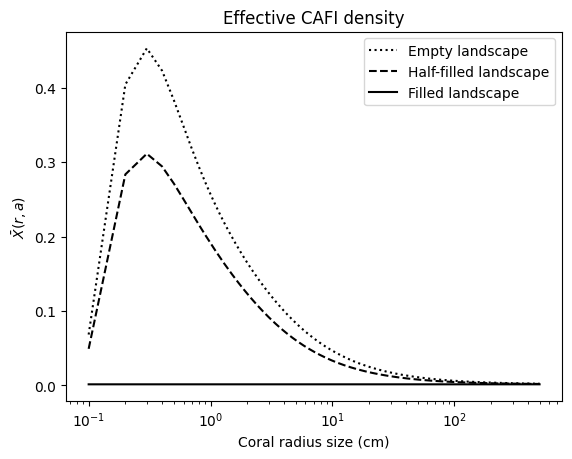

In [18]:
plt.figure()
plt.semilogx(rData, X[0,:], linestyle = ':', color ='black', label = 'Empty landscape')
plt.semilogx(rData, X[501,:], linestyle = '--', color ='black', label = 'Half-filled landscape')
plt.semilogx(rData, X[-1,:], linestyle = '-', color ='black', label = 'Filled landscape')
plt.legend()
plt.xlabel('Coral radius size (cm)')
plt.ylabel(r'$\bar{X}(r,a)$')
plt.title('Effective CAFI density')